In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial.distance import cdist
from math import pi 

In [5]:
# Chemin vers le fichier GZIP
gzip_file_path = "C:/Users/HanSAriEle/OneDrives/Desktop/PROJET_TUTORE/database_quality_ofair.csv.gz"

# Lire le fichier CSV directement depuis le fichier GZIP
data = pd.read_csv(gzip_file_path, compression='gzip')

# Afficher les premières lignes du DataFrame pour vérifier
data.head()

,Date,City,Country_Name,Continent,aqi,co,neph,no2,o3,pm10,pm25,so2,Categorie
0,2019-01-01,Addis Ababa,Ethiopia,Africa,38.0,1.933333,23.333333,7.333333,16.533333,15.333333,38.000000,1.266667,Bon
1,2019-01-01,Adelaide,Australia,Oceania,7.0,0.100000,3.666667,0.100000,0.000000,7.000000,6.000000,0.100000,Bon
2,2019-01-01,Barcelona,Spain,Europe,27.0,0.100000,9.666667,17.000000,4.900000,27.000000,27.666667,4.600000,Bon
3,2019-01-01,Bilbao,Spain,Europe,68.0,0.100000,39.000000,12.800000,3.300000,23.000000,68.000000,4.000000,Modéré
4,2019-01-01,Bogotá,Colombia,South America,34.0,4.600000,8.666667,2.300000,8.300000,17.000000,34.000000,0.300000,Bon


**ANALYSES BIVARIEES**

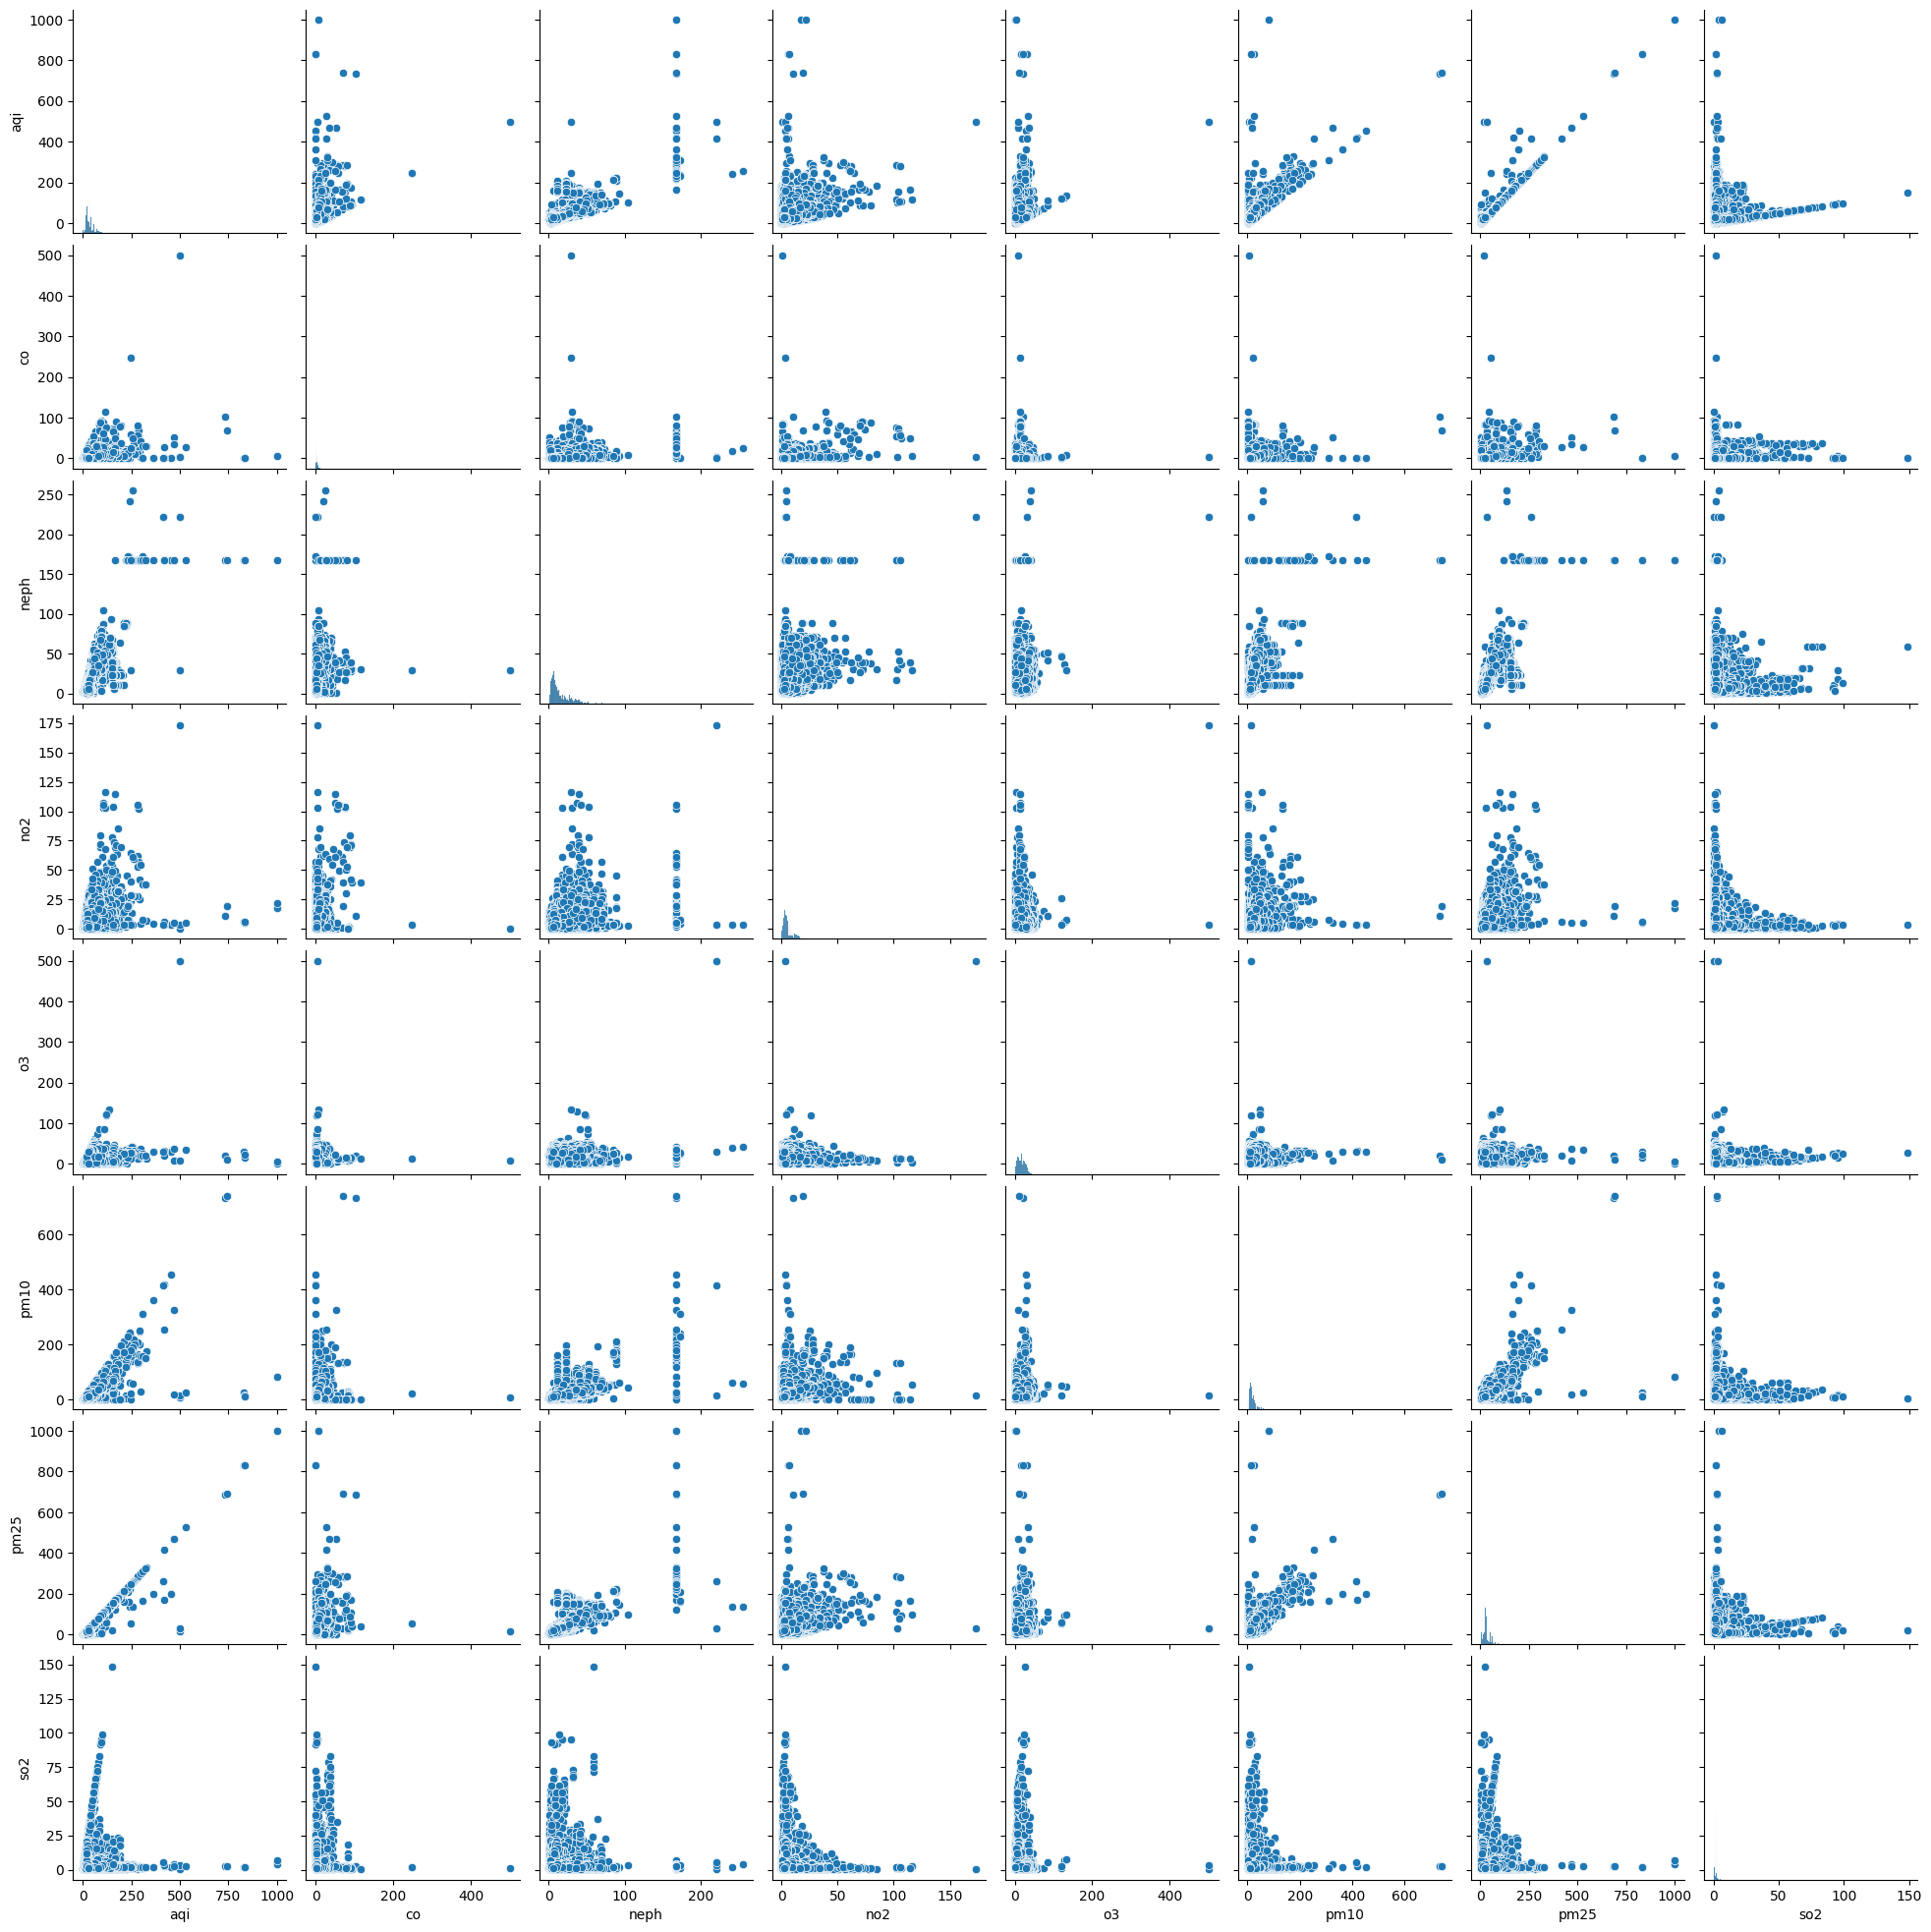

In [7]:
# Graphiques bivariés
sns.pairplot(data)
plt.show()

In [8]:
# Sélectionner uniquement les colonnes numériques
df_numeric = data.select_dtypes(include=[np.number])

# Calculer la corrélation de Spearman
correlation_spearman = df_numeric.corr(method='spearman')

# Afficher le résultat
correlation_spearman

,aqi,co,neph,no2,o3,pm10,pm25,so2
aqi,1.000000,0.294864,0.885377,0.394667,0.127409,0.762278,0.940090,0.111090
co,0.294864,1.000000,0.309639,0.084546,-0.406617,0.313392,0.316583,-0.111112
neph,0.885377,0.309639,1.000000,0.421291,-0.017007,0.852415,0.927013,0.066971
no2,0.394667,0.084546,0.421291,1.000000,-0.004998,0.388208,0.442320,0.140547
o3,0.127409,-0.406617,-0.017007,-0.004998,1.000000,0.004168,0.003024,0.168610
pm10,0.762278,0.313392,0.852415,0.388208,0.004168,1.000000,0.804426,0.087149
pm25,0.940090,0.316583,0.927013,0.442320,0.003024,0.804426,1.000000,0.092797
so2,0.111090,-0.111112,0.066971,0.140547,0.168610,0.087149,0.092797,1.000000


**CLUSTERING PAR VILLES**

In [9]:
# Sélectionner uniquement les colonnes numériques pour l'agrégation
numeric_columns = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']
non_numeric_columns = ['City', 'Country_Name', 'Continent']

# Vérifier que les colonnes sélectionnées existent dans les données
for col in numeric_columns:
    if col not in data.columns:
        print(f"Warning: {col} not found in data columns")


# Agréger les données par ville (en utilisant les colonnes numériques)
agg_data_numeric = data.groupby('City')[numeric_columns].mean().reset_index()

# Conserver les informations non numériques pour les premières occurrences
agg_data_non_numeric = data[non_numeric_columns].drop_duplicates(subset=['City']).reset_index(drop=True)

# Combiner les données agrégées avec les informations non numériques
agg_data = pd.merge(agg_data_non_numeric, agg_data_numeric, on='City')


# Standardiser les données
X = agg_data[numeric_columns]
scaler = StandardScaler()
df_normalized = scaler.fit_transform(X)

# ACP
pca = PCA()
df_pca = pca.fit_transform(df_normalized)

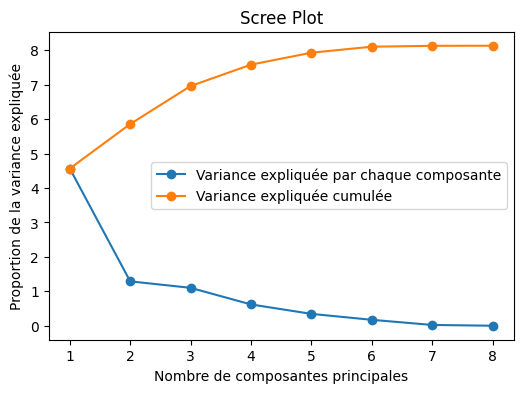

In [10]:
# Calculer la variance expliquée cumulée
explained_variance = pca.explained_variance_

cumulative_explained_variance = np.cumsum(explained_variance)

# Créer un scree plot avec la variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', label='Variance expliquée par chaque composante')
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, 'o-', label='Variance expliquée cumulée')
plt.title('Scree Plot')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de la variance expliquée')
plt.legend()
plt.show()

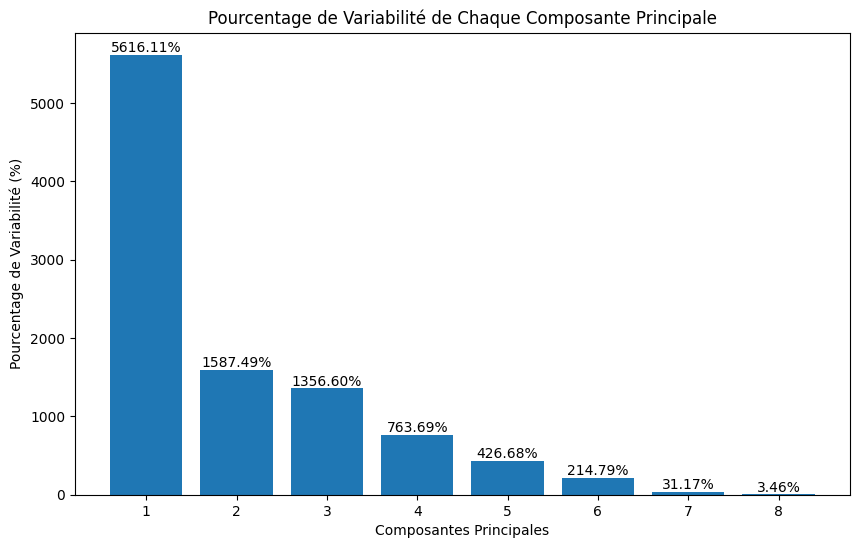

In [120]:
# Histogramme du pourcentage de variabilité de chaque composante principale
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100)
plt.title('Pourcentage de Variabilité de Chaque Composante Principale')
plt.xlabel('Composantes Principales')
plt.ylabel('Pourcentage de Variabilité (%)')
plt.xticks(range(1, len(explained_variance) + 1))
for i, v in enumerate(explained_variance * 100):
    plt.text(i + 1, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')
plt.show()

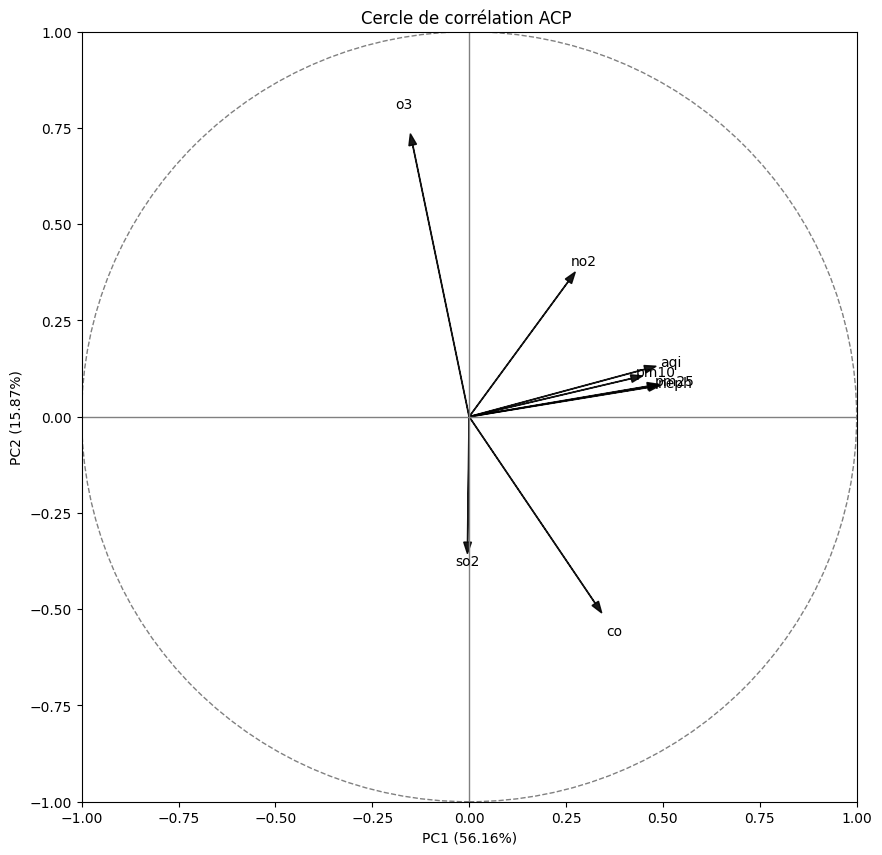

In [123]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
plt.figure(figsize=(10, 10))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_numeric.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)

# Ajouter les pourcentages de variance expliquée sur les étiquettes des axes
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
plt.title('Cercle de corrélation ACP')

plt.title('Cercle de corrélation ACP ')

# Afficher la figure
plt.show()

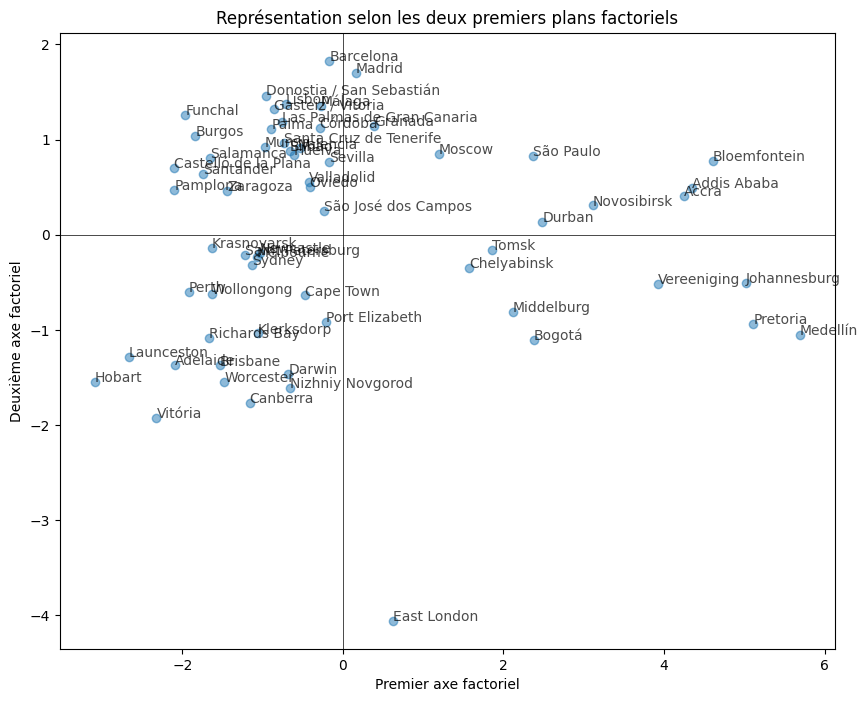

In [14]:
# Créer le graphique du premier plan factoriel
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)

# Ajouter des étiquettes pour chaque point (ville)
for i, city in enumerate(data['City'].unique()):
    ax.annotate(city, (df_pca[i, 0], df_pca[i, 1]), alpha=0.7)

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax.set_xlabel('Premier axe factoriel')
ax.set_ylabel('Deuxième axe factoriel')

# Titre du graphique
plt.title('Représentation selon les deux premiers plans factoriels')

# Afficher le graphique
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

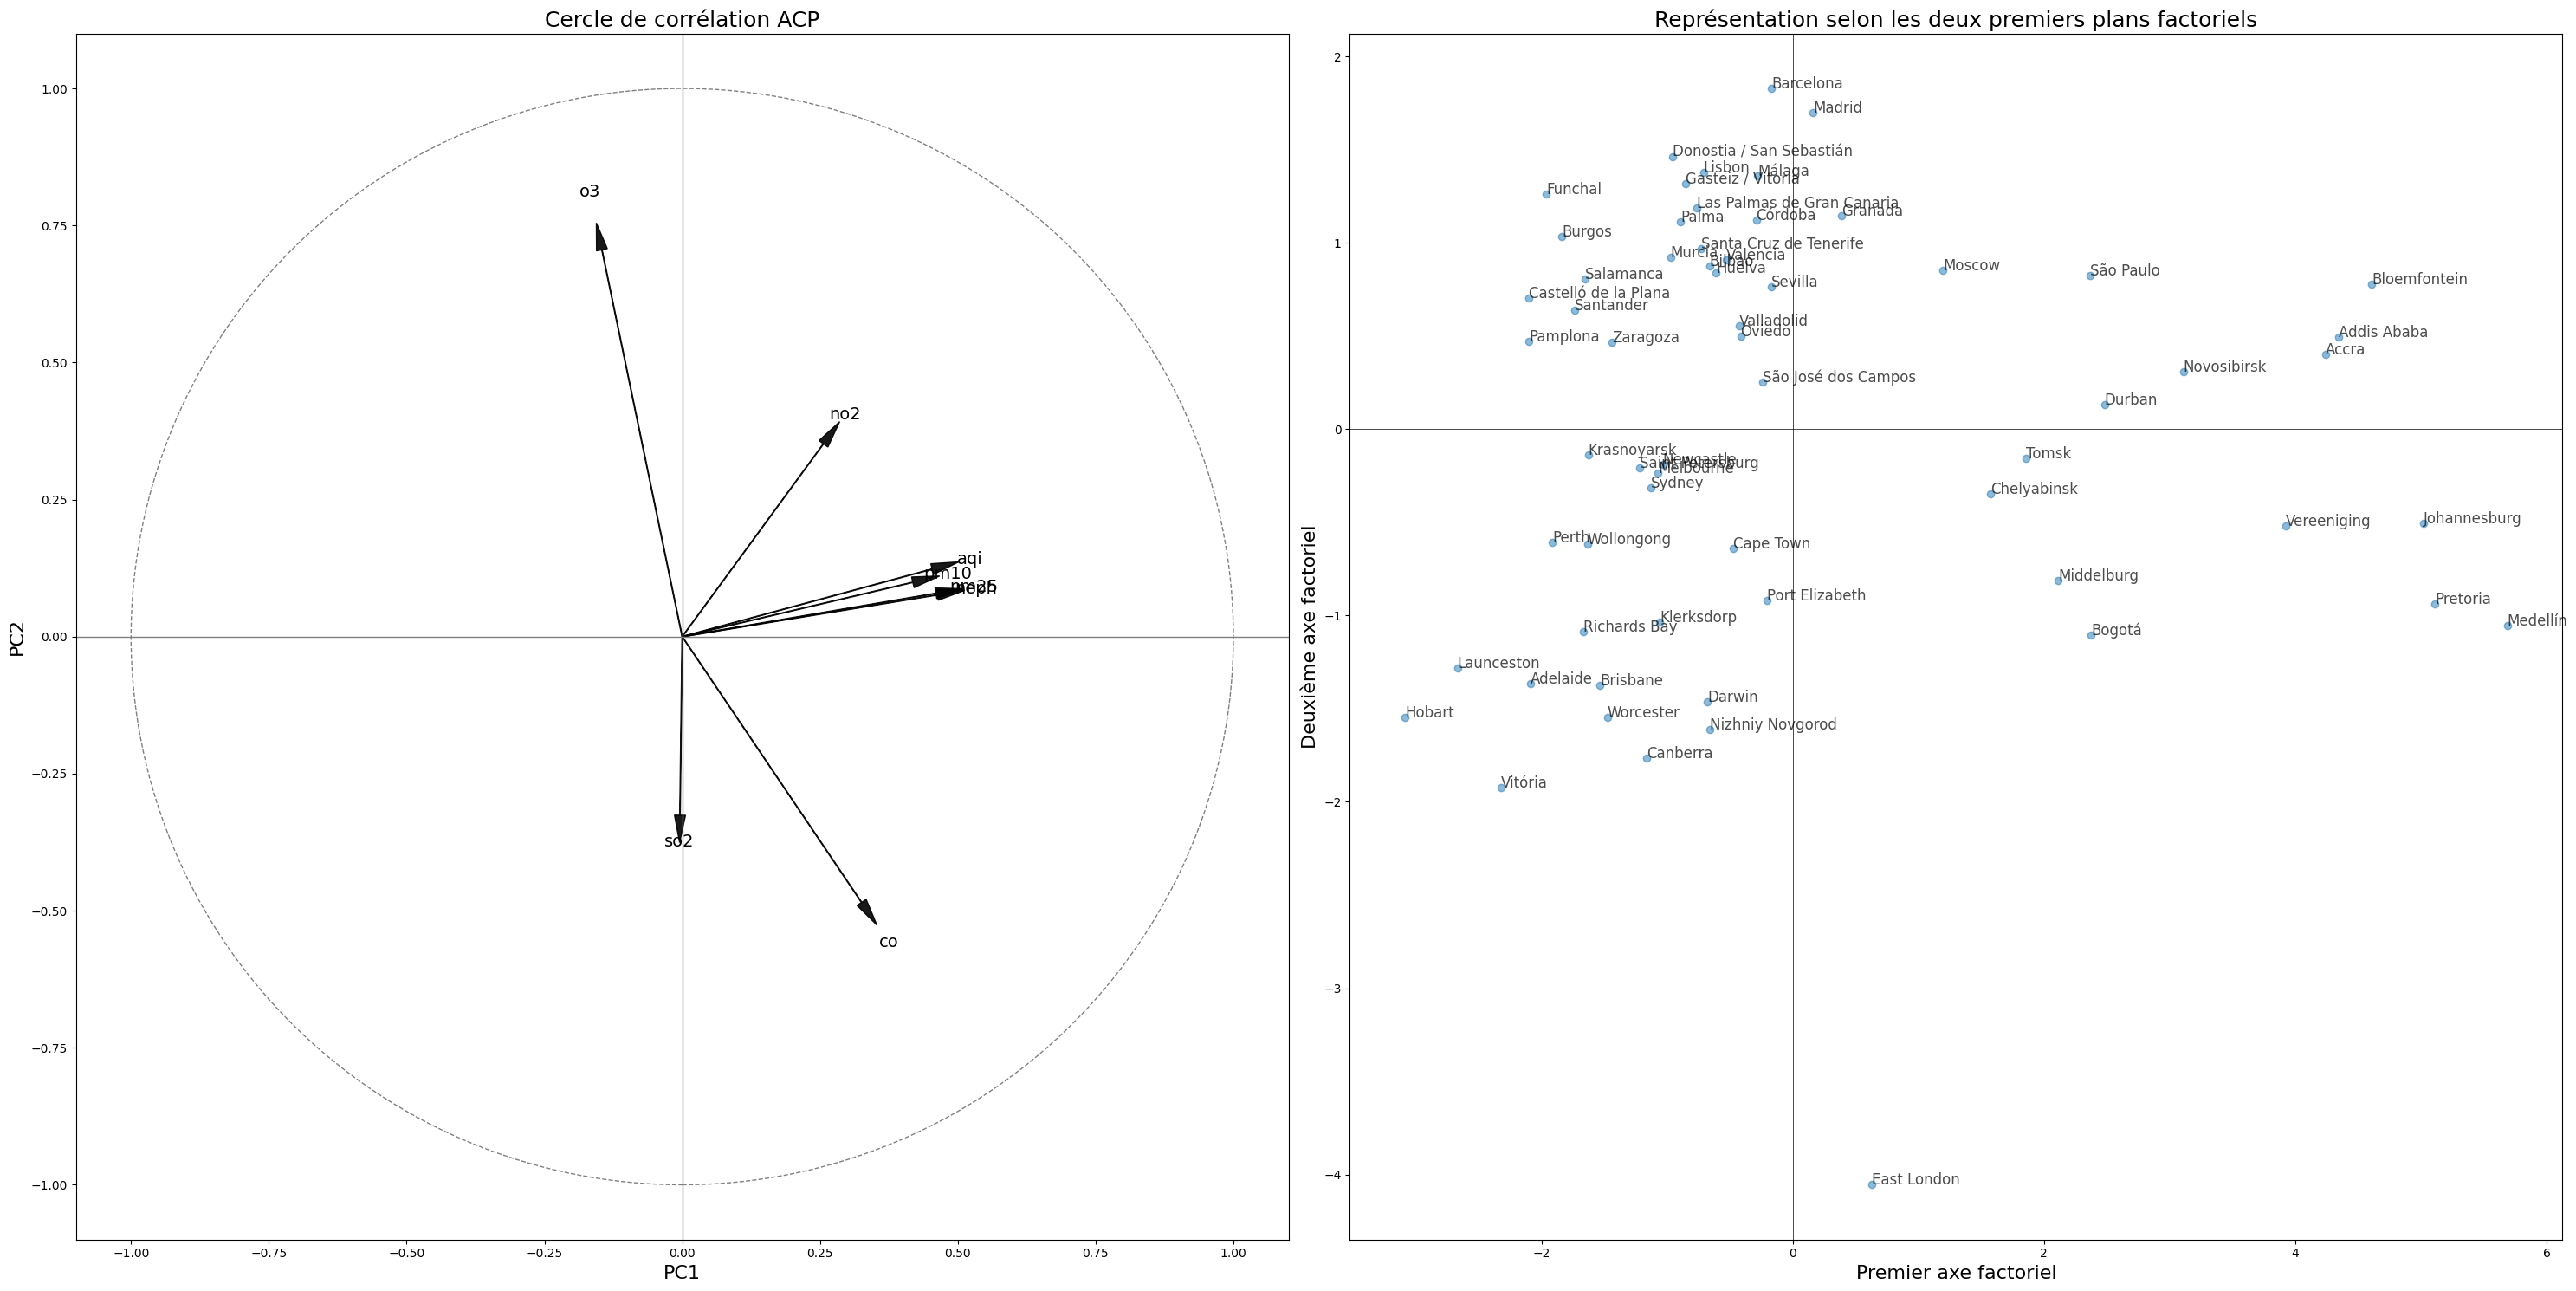

In [121]:
# Créer une figure avec deux sous-graphes côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Premier sous-graphe: Cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]

# Placer les vecteurs des variables
for i in range(n):
    ax1.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02, head_length=0.05)
    ax1.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, numeric_columns[i], color='k', ha='center', va='center', fontsize=14)

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax1.add_artist(circle)

# Ajuster les limites et les axes
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.axhline(0, color='gray', linewidth=1)
ax1.axvline(0, color='gray', linewidth=1)
ax1.set_xlabel('PC1', fontsize=16)
ax1.set_ylabel('PC2', fontsize=16)
ax1.set_title('Cercle de corrélation ACP', fontsize=18)

# Deuxième sous-graphe: Premier plan factoriel
ax2.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)

# Ajouter des étiquettes pour chaque point (ville)
for i, city in enumerate(agg_data['City']):
    ax2.annotate(city, (df_pca[i, 0], df_pca[i, 1]), alpha=0.7, fontsize=12)

# Ajouter des axes
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax2.set_xlabel('Premier axe factoriel', fontsize=16)
ax2.set_ylabel('Deuxième axe factoriel', fontsize=16)
ax2.set_title('Représentation selon les deux premiers plans factoriels', fontsize=18)

# Afficher la figure
plt.tight_layout()
plt.show

In [15]:
# Déterminer le nombre optimal de clusters (facultatif, méthode elbow)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df_normalized)
    inertia.append(kmeans.inertia_)

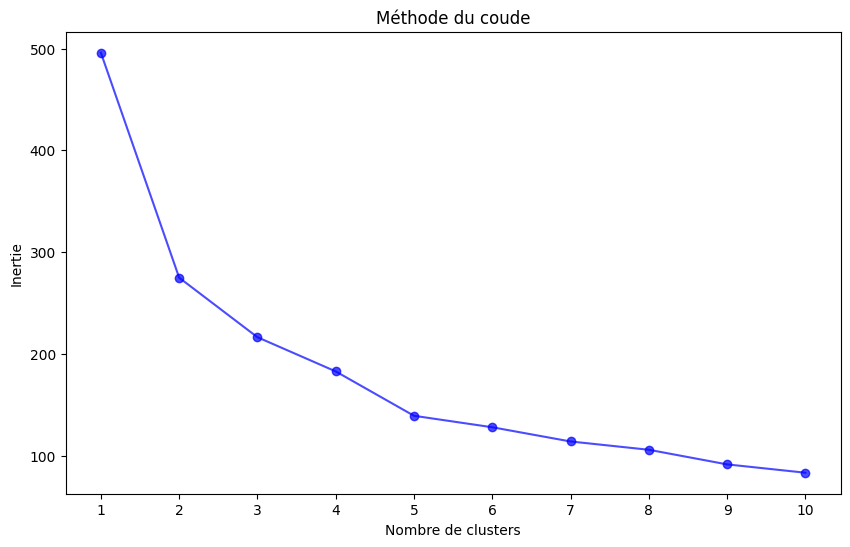

In [16]:
# Afficher les résultats avec les abscisses à l'échelle de 1
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', color='blue', alpha=0.7)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.xticks(range(1, 11))  # Assure que les étiquettes x sont des entiers de 1 à 10
plt.show()

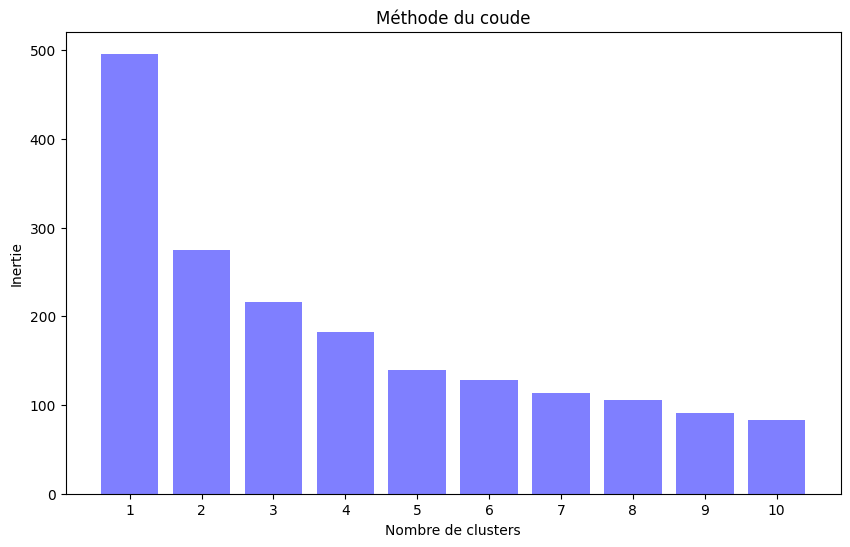

In [17]:
# Afficher les résultats sous forme d'histogramme
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), inertia, color='blue', alpha=0.5)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.xticks(range(1, 11))  # Assure que les étiquettes x sont des entiers
plt.show()

Nombre de clusters = 2, Coefficient de silhouette moyen = 0.4631712148409043
Nombre de clusters = 3, Coefficient de silhouette moyen = 0.30217198876873735
Nombre de clusters = 4, Coefficient de silhouette moyen = 0.3108522440908901
Nombre de clusters = 5, Coefficient de silhouette moyen = 0.3215593125689919
Nombre de clusters = 6, Coefficient de silhouette moyen = 0.2489450223136018
Nombre de clusters = 7, Coefficient de silhouette moyen = 0.25078194504150464
Nombre de clusters = 8, Coefficient de silhouette moyen = 0.2580903669918387
Nombre de clusters = 9, Coefficient de silhouette moyen = 0.2632317361031044
Nombre de clusters = 10, Coefficient de silhouette moyen = 0.24798343941797804


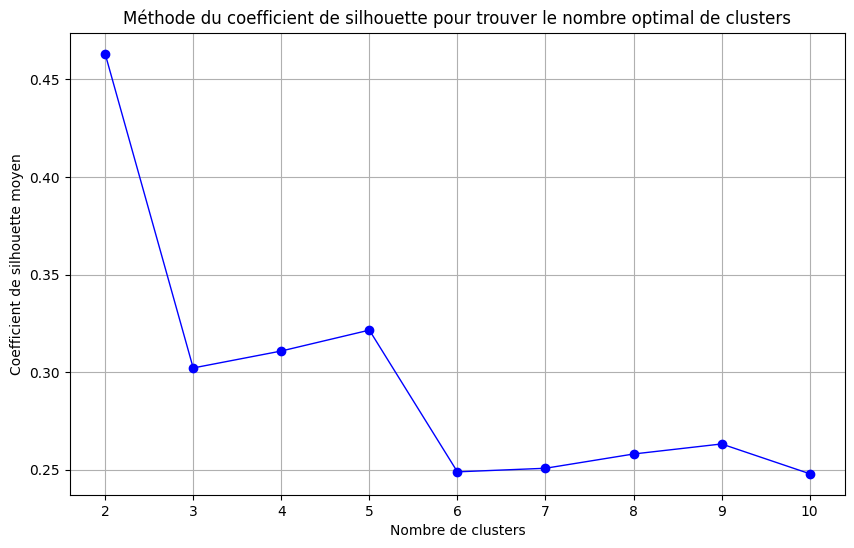

In [18]:
# Liste pour stocker les valeurs de silhouette
silhouette_scores = []

# Calculer le coefficient de silhouette pour différents nombres de clusters
for n_clusters in range(2, 11):  # Essayer de 2 à 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_normalized)
    silhouette_avg = silhouette_score(df_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Nombre de clusters = {n_clusters}, Coefficient de silhouette moyen = {silhouette_avg}")

# Tracer le graphique du coefficient de silhouette en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b', linewidth=1)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette moyen')
plt.title('Méthode du coefficient de silhouette pour trouver le nombre optimal de clusters')
plt.grid(True)
plt.xticks(range(2, 11))
plt.show()

In [124]:
# Appliquer K-means avec un nombre de clusters choisi (par exemple, 3)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
agg_data['Cluster'] = kmeans.fit_predict(df_normalized)

# Afficher les différentes villes dans chaque cluster
for cluster in range(n_clusters):
    print(f"Cluster {cluster + 1}:")
    cluster_data = agg_data[agg_data['Cluster'] == cluster][['City', 'Country_Name']]
    city_country_pairs = list(cluster_data.itertuples(index=False, name=None))
    print(city_country_pairs)
    print("\n")

Cluster 1:
[('Adelaide', 'Australia'), ('Barcelona', 'Spain'), ('Bilbao', 'Spain'), ('Brisbane', 'Australia'), ('Burgos', 'Spain'), ('Castelló de la Plana', 'Spain'), ('Córdoba', 'Spain'), ('Darwin', 'Australia'), ('Donostia / San Sebastián', 'Spain'), ('Funchal', 'Portugal'), ('Gasteiz / Vitoria', 'Spain'), ('Granada', 'Spain'), ('Hobart', 'Australia'), ('Huelva', 'Spain'), ('Klerksdorp', 'South Africa'), ('Las Palmas de Gran Canaria', 'Spain'), ('Launceston', 'Australia'), ('Lisbon', 'Portugal'), ('Madrid', 'Spain'), ('Melbourne', 'Australia'), ('Moscow', 'Russian Federation'), ('Murcia', 'Spain'), ('Málaga', 'Spain'), ('Newcastle', 'Australia'), ('Oviedo', 'Spain'), ('Palma', 'Spain'), ('Pamplona', 'Spain'), ('Perth', 'Australia'), ('Port Elizabeth', 'South Africa'), ('Richards Bay', 'South Africa'), ('Salamanca', 'Spain'), ('Santa Cruz de Tenerife', 'Spain'), ('Santander', 'Spain'), ('Sevilla', 'Spain'), ('Sydney', 'Australia'), ('São José dos Campos', 'Brazil'), ('Valencia', 'Spai

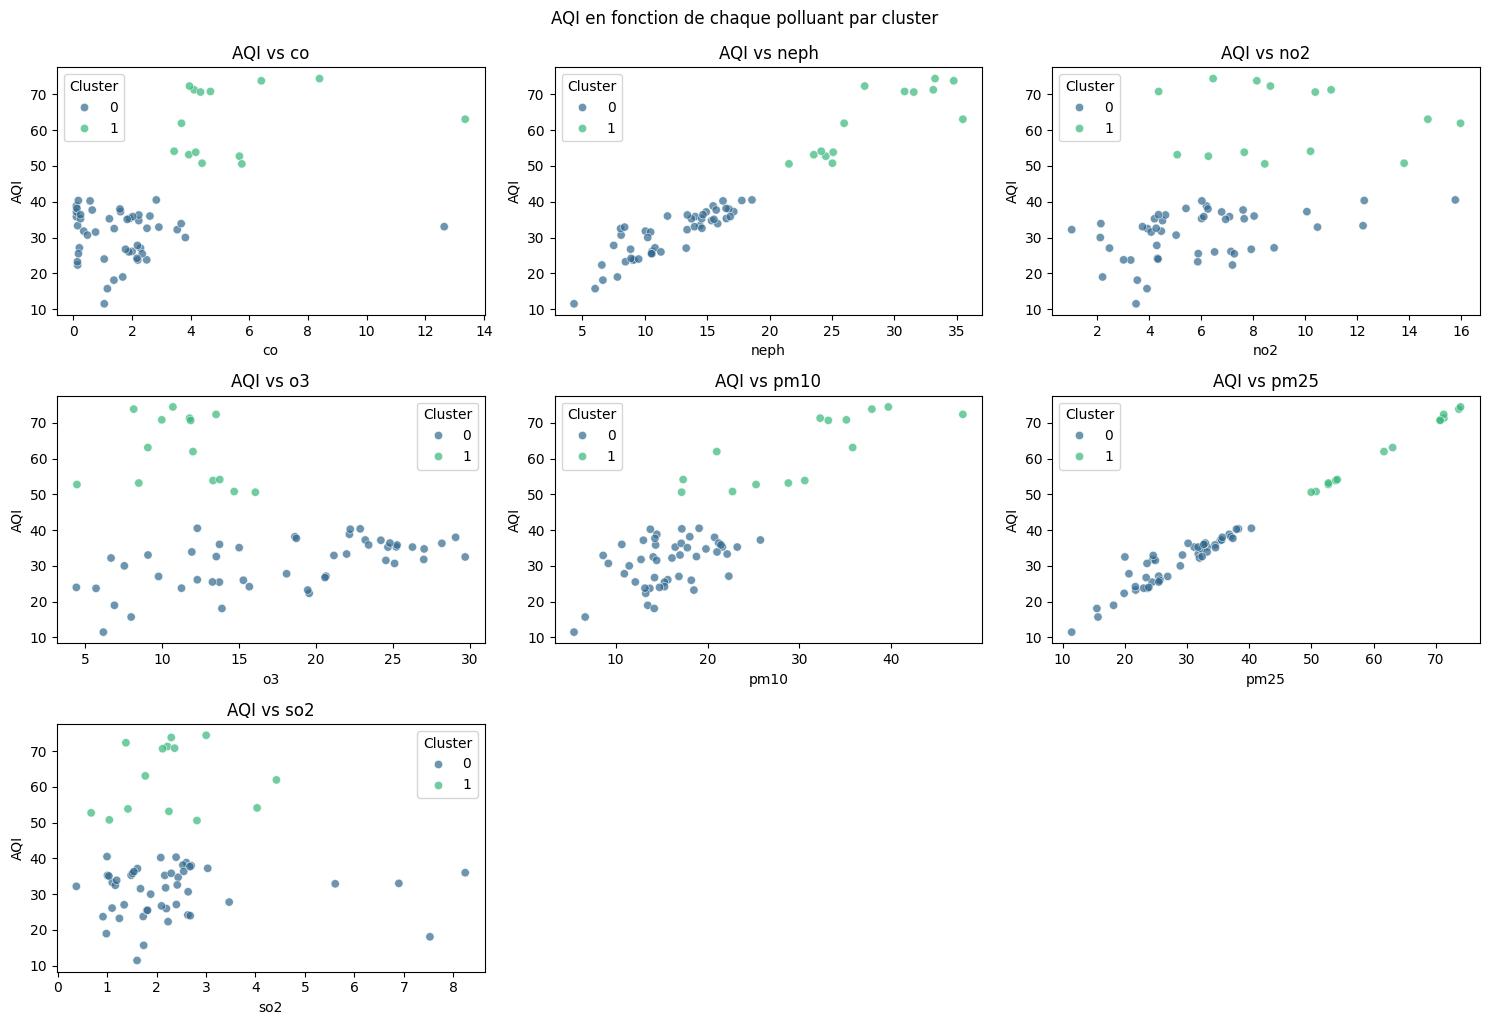

In [35]:
# Liste des polluants à examiner
pollutants = ['co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']

# Création des graphiques de dispersion pour chaque polluant
plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants, start=1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=pollutant, y='aqi', data=agg_data, hue='Cluster', palette='viridis', alpha=0.7)
    plt.title(f'AQI vs {pollutant}')
    plt.xlabel(pollutant)
    plt.ylabel('AQI')
    plt.tight_layout()

# Ajustement global des sous-titres
plt.suptitle('AQI en fonction de chaque polluant par cluster', y=1.02)
plt.show()

**ANALYSE FACTORIELLE DISCRIMINANTE**

In [125]:
# Séparation des caractéristiques et de la variable cible
X = agg_data[['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
y = agg_data['Cluster']

# Récupérer les coefficients des fonctions discriminantes
coefficients = lda.coef_
intercepts = lda.intercept_

# Afficher les coefficients et les intercepts
variable_names = X.columns

print("Coefficients de la fonction discriminante :")
equation = " + ".join(f"{coef[j]:.4f}*{variable_names[j]}" for j in range(len(coef)))
print(f"F(x) = {equation} + {intercept:.4f}\n")

Coefficients de la fonction discriminante :
F(x) = 1.0691*aqi + 0.0411*co + 0.1728*neph + 0.3059*no2 + -0.6441*o3 + -0.0757*pm10 + -0.3578*pm25 + -0.3800*so2 + -28.7725



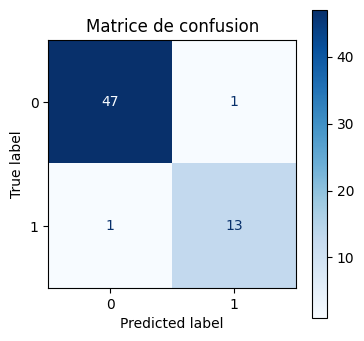

In [129]:
y_pred = lda.predict(X)

# Création de la matrice de confusion
cm = confusion_matrix(y, y_pred)

# Affichage de la matrice de confusion avec taille réduite
fig, ax = plt.subplots(figsize=(4, 4))  # Ajuster la taille de l'affichage (par exemple, 4x4 pouces)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matrice de confusion')
plt.show()

In [127]:
# Calcul des métriques
tn, fp, fn, tp = cm.ravel()

# Taux de bon classement
taux_bon_classement = (tp + tn) / (tp + tn + fp + fn)

# Taux de mauvais classement
taux_mauvais_classement = (fp + fn) / (tp + tn + fp + fn)

# Sensibilité (Recall ou Taux de Vrais Positifs)
sensibilite = tp / (tp + fn)

# Spécificité (Taux de Vrais Négatifs)
specificite = tn / (tn + fp)

# Exactitude (Precision)
exactitude = tp / (tp + fp)

print(f'Taux de bon classement: {taux_bon_classement:.2f}')
print(f'Taux de mauvais classement: {taux_mauvais_classement:.2f}')
print(f'Sensibilité: {sensibilite:.2f}')
print(f'Spécificité: {specificite:.2f}')
print(f'Exactitude: {exactitude:.2f}')

Taux de bon classement: 0.97
Taux de mauvais classement: 0.03
Sensibilité: 0.93
Spécificité: 0.98
Exactitude: 0.93
